# CNN-RNN 结构用于图像处理

## 导入数据

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow import keras

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

## 简单的 cnn-rnn 结构

In [4]:
from tensorflow.keras import layers
model = keras.Sequential()

In [5]:
x_shape = x_train.shape
model.add(layers.Conv2D(input_shape=(x_shape[1], x_shape[2], x_shape[3]),
                       filters=32, kernel_size=(3,3), strides=(1,1), 
                       padding='same', activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

In [6]:
print(model.output_shape)

(None, 16, 16, 32)


In [7]:
import tensorflow as tf

model.add(layers.Reshape(target_shape=(16*16, 32)))
# model.add(layers.LSTM(50, return_sequences=False))
model.add(tf.compat.v1.keras.layers.CuDNNLSTM(50, return_sequences=False))
model.add(layers.Dense(10, activation='softmax'))

In [8]:
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
reshape (Reshape)            (None, 256, 32)           0         
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (None, 50)                16800     
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 18,206
Trainable params: 18,206
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time
history = model.fit(x_train, y_train, batch_size=32, epochs=5, validation_split=0.1)

W0910 00:16:24.815689  3368 deprecation.py:323] From C:\Users\44310\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 32s 711us/sample - loss: 2.0608 - accuracy: 0.2381 - val_loss: 1.9364 - val_accuracy: 0.2842
Epoch 2/5
45000/45000 [==============================] - 31s 679us/sample - loss: 1.8595 - accuracy: 0.3082 - val_loss: 1.8067 - val_accuracy: 0.3276
Epoch 3/5
45000/45000 [==============================] - 30s 676us/sample - loss: 1.7414 - accuracy: 0.3505 - val_loss: 1.6510 - val_accuracy: 0.3854
Epoch 4/5
45000/45000 [==============================] - 31s 686us/sample - loss: 1.6434 - accuracy: 0.3861 - val_loss: 1.5799 - val_accuracy: 0.3960
Epoch 5/5
45000/45000 [==============================] - 31s 684us/sample - loss: 1.5651 - accuracy: 0.4190 - val_loss: 1.5119 - val_accuracy: 0.4248
Wall time: 2min 35s


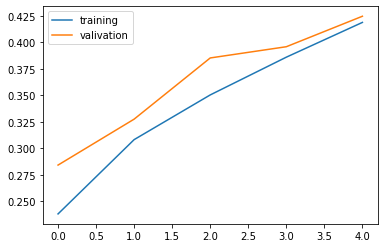

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()

In [11]:
res = model.evaluate(x_test,y_test)

10000/10000 [==============================] - 3s 338us/sample - loss: 1.5333 - accuracy: 0.4272


## CNN和LSTM结果合并

In [12]:
x_shape = x_train.shape
inn = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
conv = layers.Conv2D(filters=32,kernel_size=(3,3), strides=(1,1),
                    padding='same', activation='relu')(inn)
pool = layers.MaxPool2D(pool_size=(2,2), padding='same')(conv)
flat = layers.Flatten()(pool)
dense1 = layers.Dense(64)(flat)

In [13]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(inn)
# lstm_layer = layers.LSTM(32, return_sequences=False)(reshape)
lstm_layer = tf.compat.v1.keras.layers.CuDNNLSTM(32, return_sequences=False)(reshape)
dense2 = layers.Dense(64)(lstm_layer)

In [14]:
merged_layer = layers.concatenate([dense1, dense2])
outt = layers.Dense(10,activation='softmax')(merged_layer)
model = keras.Model(inputs=inn, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 1024, 3)      0           input_1[0][0]                    
______________________________________________________________________________________________

In [15]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64, epochs=5, validation_split=0.1)

Train on 45000 samples, validate on 5000 samples
Epoch 1/5
45000/45000 [==============================] - 24s 540us/sample - loss: 14.5148 - accuracy: 0.0995 - val_loss: 14.4128 - val_accuracy: 0.1058
Epoch 2/5
45000/45000 [==============================] - 24s 524us/sample - loss: 14.5167 - accuracy: 0.0994 - val_loss: 14.4128 - val_accuracy: 0.1058 - loss:
Epoch 3/5
45000/45000 [==============================] - 24s 523us/sample - loss: 14.5167 - accuracy: 0.0994 - val_loss: 14.4128 - val_accuracy: 0.1058
Epoch 4/5
45000/45000 [==============================] - 23s 519us/sample - loss: 14.5167 - accuracy: 0.0994 - val_loss: 14.4128 - val_accuracy: 0.1058
Epoch 5/5
45000/45000 [==============================] - 23s 519us/sample - loss: 14.5167 - accuracy: 0.0994 - val_loss: 14.4128 - val_accuracy: 0.1058
Wall time: 1min 58s


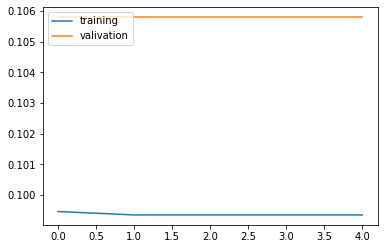

In [16]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'valivation'], loc='upper left')
plt.show()